In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as dist
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Simulate a Physical Dataset (2D Harmonic Oscillator)
def generate_harmonic_data(n_samples=1000):
    # Simulate particle positions under a 2D harmonic potential
    # Potential energy: V(x, y) = 0.5 * k * (x^2 + y^2)
    k = 1.0  # Spring constant
    x = np.random.normal(0, 1.0 / np.sqrt(k), n_samples)  # x ~ N(0, 1/sqrt(k))
    y = np.random.normal(0, 1.0 / np.sqrt(k), n_samples)  # y ~ N(0, 1/sqrt(k))
    return np.stack([x, y], axis=1)

data = generate_harmonic_data()
data_tensor = torch.tensor(data, dtype=torch.float32)

# 2. Define a Simple Neural Network for RealNVP
class AffineCoupling(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AffineCoupling, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2 * 2)  # Outputs scale and shift
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)  # Split input into two parts
        params = self.net(x_a)
        s, t = params.chunk(2, dim=1)  # Scale and translation
        s = torch.tanh(s)  # Ensure scale is bounded
        x_b = x_b * torch.exp(s) + t  # Transform the second half
        log_det = s.sum(dim=1)  # Log determinant for density estimation
        return torch.cat([x_a, x_b], dim=1), log_det

# 3. Define the Normalizing Flow
class NormalizingFlow(nn.Module):
    def __init__(self, input_dim, n_layers, hidden_dim):
        super(NormalizingFlow, self).__init__()
        self.base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
        self.layers = nn.ModuleList(
            [AffineCoupling(input_dim, hidden_dim) for _ in range(n_layers)]
        )

    def forward(self, x):
        log_det_sum = 0
        z = x
        for layer in self.layers:
            z, log_det = layer(z)
            log_det_sum += log_det
        return z, log_det_sum

    def inverse(self, z):
        x = z
        for layer in reversed(self.layers):
            x_a, x_b = x.chunk(2, dim=1)
            params = layer.net(x_a)
            s, t = params.chunk(2, dim=1)
            s = torch.tanh(s)
            x_b = (x_b - t) * torch.exp(-s)
            x = torch.cat([x_a, x_b], dim=1)
        return x

    def log_prob(self, x):
        z, log_det = self.forward(x)
        log_prob_base = self.base_dist.log_prob(z).sum(dim=1)
        return log_prob_base + log_det

# 4. Training the Model
input_dim = 2  # 2D data (x, y positions)
n_layers = 4   # Number of coupling layers
hidden_dim = 64
flow = NormalizingFlow(input_dim, n_layers, hidden_dim)
optimizer = torch.optim.Adam(flow.parameters(), lr=0.001)

n_epochs = 500
batch_size = 128
for epoch in range(n_epochs):
    perm = torch.randperm(data_tensor.size(0))
    for i in range(0, data_tensor.size(0), batch_size):
        batch = data_tensor[perm[i:i + batch_size]]
        optimizer.zero_grad()
        loss = -flow.log_prob(batch).mean()  # Negative log-likelihood
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 5. Generate Samples and Visualize
with torch.no_grad():
    z_samples = flow.base_dist.sample((1000,))
    generated_samples = flow.inverse(z_samples).numpy()


Epoch 0, Loss: 3.0075
Epoch 50, Loss: 2.9503
Epoch 100, Loss: 2.7924
Epoch 150, Loss: 2.5866
Epoch 200, Loss: 2.8432
Epoch 250, Loss: 2.7165
Epoch 300, Loss: 2.7415
Epoch 350, Loss: 2.9821
Epoch 400, Loss: 2.7648
Epoch 450, Loss: 2.8014


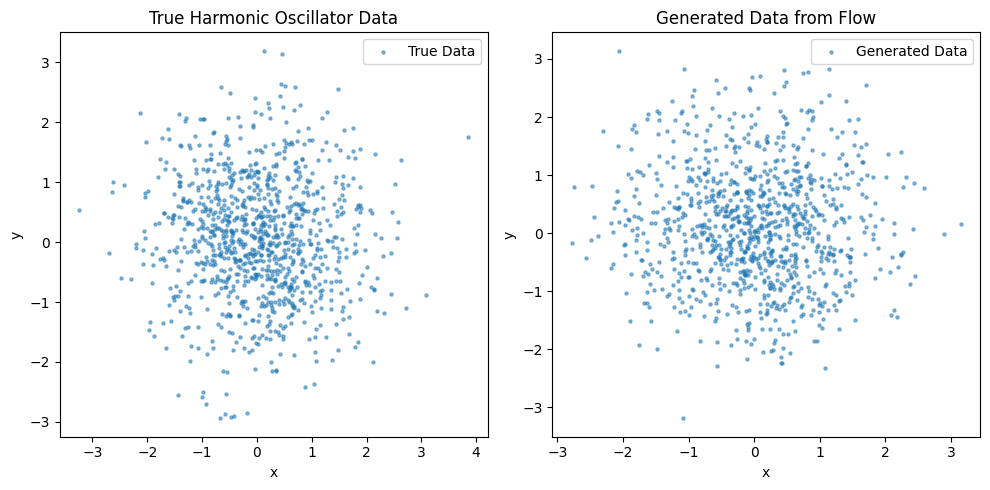

In [2]:
# Plot original data vs. generated data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.5, label="True Data")
plt.title("True Harmonic Oscillator Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=5, alpha=0.5, label="Generated Data")
plt.title("Generated Data from Flow")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()